# Assignment 2 – Autumn 2025/26
## Flight Delays

This notebook implements all three tasks of the assignment:

1. **Data preparation and characterisation**  
2. **Classification and evaluation**  
3. **Predictive feature analysis**

In [1]:
# 1. Import libraries and load data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

schedule = pd.read_csv('flights_schedule.csv')
conditions = pd.read_csv('flight_conditions_outcomes.csv')

print('Schedule shape:', schedule.shape)
print('Conditions shape:', conditions.shape)
schedule.head()


Schedule shape: (3000, 17)
Conditions shape: (3000, 4)


,flight_id,flight_date,sched_dep_time,sched_arr_time,carrier_code,carrier,flight_number,origin,origin_name,origin_city,origin_country,dest,dest_name,dest_city,dest_country,distance_km,aircraft_type
0,BA8305-478093,2024-08-20,22:10,23:24,BA,British Airways,BA8305,SNN,Shannon Airport,Shannon,Ireland,LCY,London City Airport,London,United Kingdom,627,Regional
1,FR3341-388038,2024-12-03,21:15,21:47,FR,Ryanair,FR3341,BFS,Belfast International Airport,Belfast,United Kingdom,DUB,Dublin Airport,Dublin,Ireland,138,Regional
2,U22034-811074,2024-04-17,11:35,12:39,U2,easyJet,U22034,LHR,London Heathrow Airport,London,United Kingdom,GLA,Glasgow Airport,Glasgow,United Kingdom,555,Regional
3,U22075-638687,2024-03-24,06:00,06:20,U2,easyJet,U22075,LGW,London Gatwick Airport,London,United Kingdom,LCY,London City Airport,London,United Kingdom,42,Widebody
4,BA8888-064952,2024-11-12,18:40,19:51,BA,British Airways,BA8888,SNN,Shannon Airport,Shannon,Ireland,LGW,London Gatwick Airport,London,United Kingdom,623,Narrowbody


## 1. Data preparation and characterisation

### 1.1 Merge the two sources into a single dataset

In [2]:
# Merge on the common flight_id key
combined = pd.merge(schedule, conditions, on='flight_id')
print('Combined shape:', combined.shape)
combined.head()


Combined shape: (3000, 20)


,flight_id,flight_date,sched_dep_time,sched_arr_time,carrier_code,carrier,flight_number,origin,origin_name,origin_city,origin_country,dest,dest_name,dest_city,dest_country,distance_km,aircraft_type,precipitation,wind,dep_delay
0,BA8305-478093,2024-08-20,22:10,23:24,BA,British Airways,BA8305,SNN,Shannon Airport,Shannon,Ireland,LCY,London City Airport,London,United Kingdom,627,Regional,Dry,Calm,2
1,FR3341-388038,2024-12-03,21:15,21:47,FR,Ryanair,FR3341,BFS,Belfast International Airport,Belfast,United Kingdom,DUB,Dublin Airport,Dublin,Ireland,138,Regional,Dry,VeryWindy,20
2,U22034-811074,2024-04-17,11:35,12:39,U2,easyJet,U22034,LHR,London Heathrow Airport,London,United Kingdom,GLA,Glasgow Airport,Glasgow,United Kingdom,555,Regional,Dry,Breezy,2
3,U22075-638687,2024-03-24,06:00,06:20,U2,easyJet,U22075,LGW,London Gatwick Airport,London,United Kingdom,LCY,London City Airport,London,United Kingdom,42,Widebody,Light,VeryWindy,34
4,BA8888-064952,2024-11-12,18:40,19:51,BA,British Airways,BA8888,SNN,Shannon Airport,Shannon,Ireland,LGW,London Gatwick Airport,London,United Kingdom,623,Narrowbody,Heavy,Breezy,0


### 1.2 Initial inspection and missing values

In [3]:
# Inspect data types and non-null counts
combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   flight_id       3000 non-null   object
 1   flight_date     3000 non-null   object
 2   sched_dep_time  3000 non-null   object
 3   sched_arr_time  3000 non-null   object
 4   carrier_code    3000 non-null   object
 5   carrier         3000 non-null   object
 6   flight_number   3000 non-null   object
 7   origin          3000 non-null   object
 8   origin_name     3000 non-null   object
 9   origin_city     3000 non-null   object
 10  origin_country  3000 non-null   object
 11  dest            3000 non-null   object
 12  dest_name       3000 non-null   object
 13  dest_city       3000 non-null   object
 14  dest_country    3000 non-null   object
 15  distance_km     3000 non-null   int64 
 16  aircraft_type   3000 non-null   object
 17  precipitation   3000 non-null   object
 18  wind    

In [4]:
# Check for missing values
combined.isnull().sum()


flight_id         0
flight_date       0
sched_dep_time    0
sched_arr_time    0
carrier_code      0
carrier           0
flight_number     0
origin            0
origin_name       0
origin_city       0
origin_country    0
dest              0
dest_name         0
dest_city         0
dest_country      0
distance_km       0
aircraft_type     0
precipitation     0
wind              0
dep_delay         0
dtype: int64

### 1.3 Feature engineering

In [5]:
# Create scheduled departure datetime from flight_date and sched_dep_time
combined['sched_dep_datetime'] = pd.to_datetime(
    combined['flight_date'].astype(str) + ' ' + combined['sched_dep_time'],
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)

# Departure hour
combined['dep_hour'] = combined['sched_dep_datetime'].dt.hour

# Day of week (0 = Monday, 6 = Sunday)
combined['day_of_week'] = combined['sched_dep_datetime'].dt.dayofweek

# Weekend indicator
combined['weekend'] = (combined['day_of_week'] >= 5).astype(int)

# Distance categories
def distance_category(d):
    if d < 300:
        return 'short'
    elif d < 800:
        return 'medium'
    else:
        return 'long'

combined['distance_cat'] = combined['distance_km'].apply(distance_category)

# Weather severity score based on precipitation and wind
precip_map = {'Dry': 0, 'Light': 1, 'Moderate': 2, 'Heavy': 3}
wind_map = {'Calm': 0, 'Breezy': 1, 'Windy': 2, 'VeryWindy': 3}

combined['precip_code'] = combined['precipitation'].map(precip_map)
combined['wind_code'] = combined['wind'].map(wind_map)
combined['weather_severity'] = combined['precip_code'] + combined['wind_code']

combined[['flight_id', 'sched_dep_datetime', 'dep_hour', 'day_of_week', 'weekend',
          'distance_km', 'distance_cat', 'precipitation', 'wind', 'weather_severity']].head()


,flight_id,sched_dep_datetime,dep_hour,day_of_week,weekend,distance_km,distance_cat,precipitation,wind,weather_severity
0,BA8305-478093,2024-08-20 22:10:00,22,1,0,627,medium,Dry,Calm,0
1,FR3341-388038,2024-12-03 21:15:00,21,1,0,138,short,Dry,VeryWindy,3
2,U22034-811074,2024-04-17 11:35:00,11,2,0,555,medium,Dry,Breezy,1
3,U22075-638687,2024-03-24 06:00:00,6,6,1,42,short,Light,VeryWindy,4
4,BA8888-064952,2024-11-12 18:40:00,18,1,0,623,medium,Heavy,Breezy,4


### 1.4 Create the target variable `delayed`

In [6]:
# A flight is delayed if departure delay is 15 minutes or more
combined['delayed'] = (combined['dep_delay'] >= 15).astype(int)

combined['delayed'].value_counts()


delayed
0    2383
1     617
Name: count, dtype: int64

### 1.5 Data characterisation – distributions and summary statistics

In [7]:
# Basic descriptive statistics for numeric variables
combined.describe()


,distance_km,dep_delay,sched_dep_datetime,dep_hour,day_of_week,weekend,precip_code,wind_code,weather_severity,delayed
count,3000.000000,3000.000000,3000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,395.084333,8.663667,2024-07-02 17:12:32.100000,12.577667,2.938000,0.271333,0.670333,1.067667,1.738000,0.205667
min,36.000000,0.000000,2024-01-01 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,195.000000,1.000000,2024-04-02 21:52:30,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,478.000000,4.000000,2024-07-03 13:50:00,13.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000
75%,561.000000,10.000000,2024-10-02 22:08:45,18.000000,5.000000,1.000000,1.000000,2.000000,3.000000,0.000000
max,627.000000,57.000000,2024-12-31 21:25:00,23.000000,6.000000,1.000000,3.000000,3.000000,6.000000,1.000000
std,205.661896,11.123899,NaN,6.155263,2.004369,0.444722,0.869428,0.915078,1.256669,0.404255


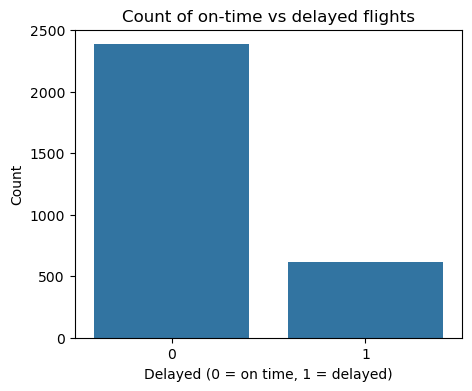

In [8]:
# Distribution of delay status
plt.figure(figsize=(5,4))
sns.countplot(x='delayed', data=combined)
plt.title('Count of on-time vs delayed flights')
plt.xlabel('Delayed (0 = on time, 1 = delayed)')
plt.ylabel('Count')
plt.show()


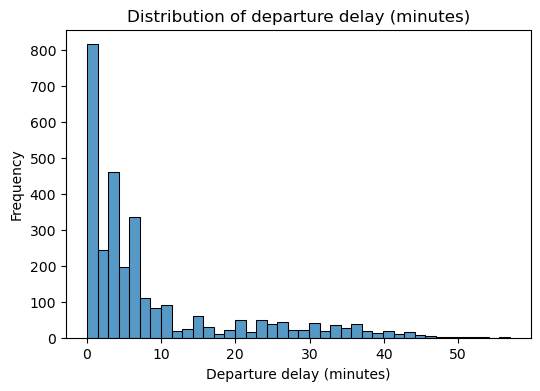

In [9]:
# Histogram of departure delay
plt.figure(figsize=(6,4))
sns.histplot(combined['dep_delay'], bins=40, kde=False)
plt.title('Distribution of departure delay (minutes)')
plt.xlabel('Departure delay (minutes)')
plt.ylabel('Frequency')
plt.show()


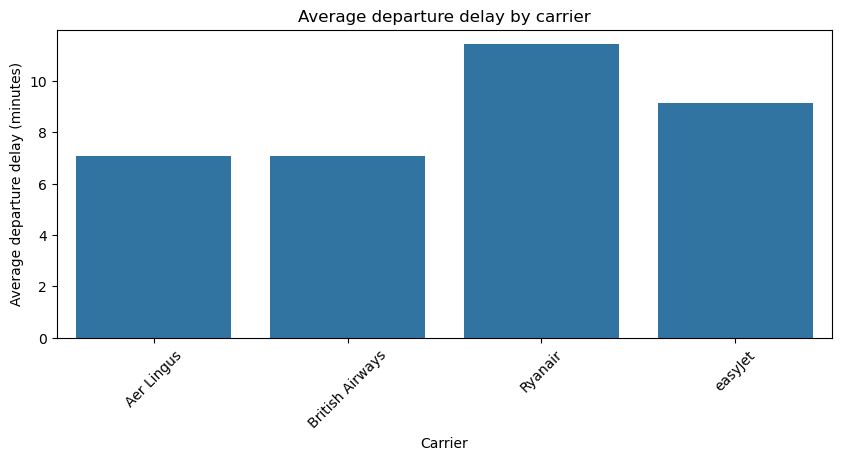

In [10]:
# Average departure delay by carrier
plt.figure(figsize=(10,4))
carrier_delay = combined.groupby('carrier')['dep_delay'].mean().reset_index()
sns.barplot(x='carrier', y='dep_delay', data=carrier_delay)
plt.title('Average departure delay by carrier')
plt.xlabel('Carrier')
plt.ylabel('Average departure delay (minutes)')
plt.xticks(rotation=45)
plt.show()


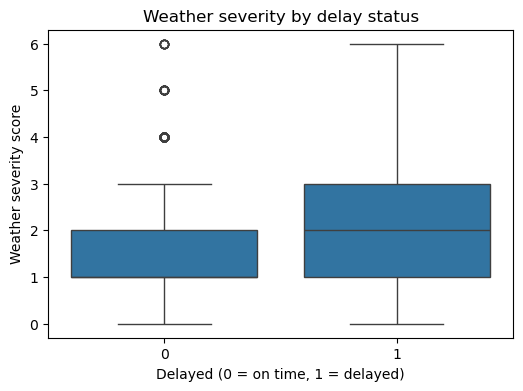

In [11]:
# Boxplot of weather severity vs delay
plt.figure(figsize=(6,4))
sns.boxplot(x='delayed', y='weather_severity', data=combined)
plt.title('Weather severity by delay status')
plt.xlabel('Delayed (0 = on time, 1 = delayed)')
plt.ylabel('Weather severity score')
plt.show()


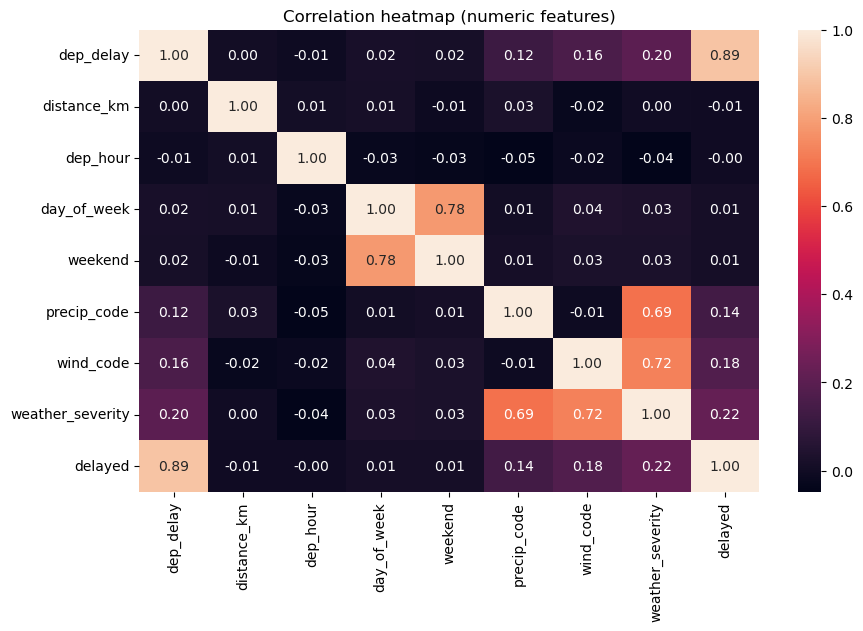

In [12]:
# Correlation heatmap for selected numeric features
numeric_cols = ['dep_delay', 'distance_km', 'dep_hour', 'day_of_week',
                'weekend', 'precip_code', 'wind_code', 'weather_severity', 'delayed']

plt.figure(figsize=(10,6))
sns.heatmap(combined[numeric_cols].corr(), annot=True, fmt='.2f')
plt.title('Correlation heatmap (numeric features)')
plt.show()


## 2. Classification and evaluation

### 2.1 Prepare data for modelling

In [13]:
# Start from combined and drop columns that should not be used as predictors
model_data = combined.copy()

# Columns to drop (IDs, text labels, high-cardinality location names, and the original datetime)
cols_to_drop = [
    'flight_id', 'flight_date', 'sched_dep_time', 'sched_arr_time',
    'origin_name', 'origin_city', 'origin_country',
    'dest_name', 'dest_city', 'dest_country',
    'sched_dep_datetime',
    # Outcome variable used to define the label
    'dep_delay'
]

model_data = model_data.drop(columns=cols_to_drop)

# One-hot encode categorical variables
model_data_encoded = pd.get_dummies(model_data, drop_first=True)

# Separate features and target
X = model_data_encoded.drop(columns=['delayed'])
y = model_data_encoded['delayed']

print('Shape of feature matrix X:', X.shape)
print('Shape of target vector y:', y.shape)


Shape of feature matrix X: (3000, 2927)
Shape of target vector y: (3000,)


In [14]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Training set size:', X_train.shape[0])
print('Test set size:', X_test.shape[0])


Training set size: 2400
Test set size: 600


### 2.2 Logistic regression

In [15]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print('LOGISTIC REGRESSION RESULTS')
print(classification_report(y_test, y_pred_lr))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_lr))
print('Accuracy:', accuracy_score(y_test, y_pred_lr))


LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       477
           1       0.57      0.13      0.21       123

    accuracy                           0.80       600
   macro avg       0.69      0.55      0.55       600
weighted avg       0.76      0.80      0.75       600

Confusion matrix:
[[465  12]
 [107  16]]
Accuracy: 0.8016666666666666


C:\Users\Mohd Ayaan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.3 Decision tree classifier

In [16]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print('DECISION TREE RESULTS')
print(classification_report(y_test, y_pred_dt))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_dt))
print('Accuracy:', accuracy_score(y_test, y_pred_dt))


DECISION TREE RESULTS
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       477
           1       0.28      0.15      0.19       123

    accuracy                           0.75       600
   macro avg       0.54      0.52      0.52       600
weighted avg       0.70      0.75      0.72       600

Confusion matrix:
[[431  46]
 [105  18]]
Accuracy: 0.7483333333333333


### 2.4 Random forest classifier

In [17]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('RANDOM FOREST RESULTS')
print(classification_report(y_test, y_pred_rf))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_rf))
print('Accuracy:', accuracy_score(y_test, y_pred_rf))


RANDOM FOREST RESULTS
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       477
           1       0.44      0.07      0.11       123

    accuracy                           0.79       600
   macro avg       0.62      0.52      0.50       600
weighted avg       0.73      0.79      0.72       600

Confusion matrix:
[[467  10]
 [115   8]]
Accuracy: 0.7916666666666666


### 2.5 Compare model performance

In [18]:
results = pd.DataFrame({
    'Model': ['Logistic regression', 'Decision tree', 'Random forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf)
    ]
})
results


,Model,Accuracy
0,Logistic regression,0.801667
1,Decision tree,0.748333
2,Random forest,0.791667


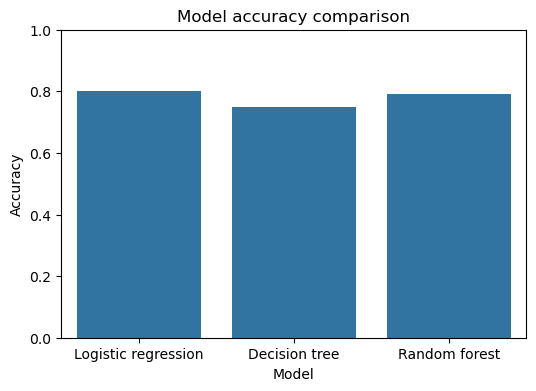

In [19]:
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.ylim(0, 1)
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.show()


## 3. Predictive feature analysis

### 3.1 Random forest feature importance

In [20]:
importances = rf.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feature_importance.head(20)


,feature,importance
1,dep_hour,0.066632
0,distance_km,0.051469
2,day_of_week,0.050242
6,weather_severity,0.037108
5,wind_code,0.025284
4,precip_code,0.022897
2919,aircraft_type_Widebody,0.018522
2918,aircraft_type_Regional,0.017518
11,carrier_Ryanair,0.015122
2926,distance_cat_short,0.014685


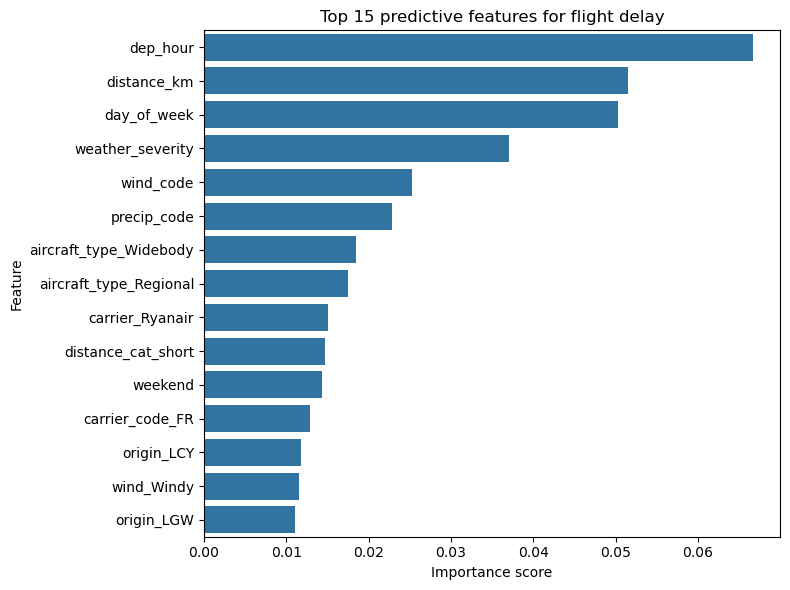

In [21]:
# Plot top 15 most important features
top_n = 15
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.title(f'Top {top_n} predictive features for flight delay')
plt.xlabel('Importance score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### 3.2 Additional exploratory plots for predictive features
The following optional plots explore how some of the key predictors relate to the likelihood of delay.

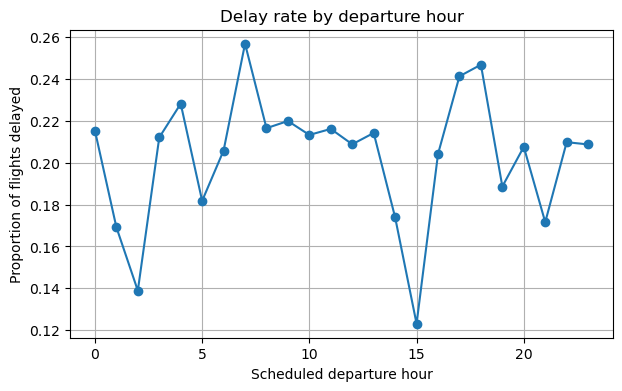

In [22]:
# Delay rate by departure hour
delay_by_hour = combined.groupby('dep_hour')['delayed'].mean()

plt.figure(figsize=(7,4))
plt.plot(delay_by_hour.index, delay_by_hour.values, marker='o')
plt.xlabel('Scheduled departure hour')
plt.ylabel('Proportion of flights delayed')
plt.title('Delay rate by departure hour')
plt.grid(True)
plt.show()


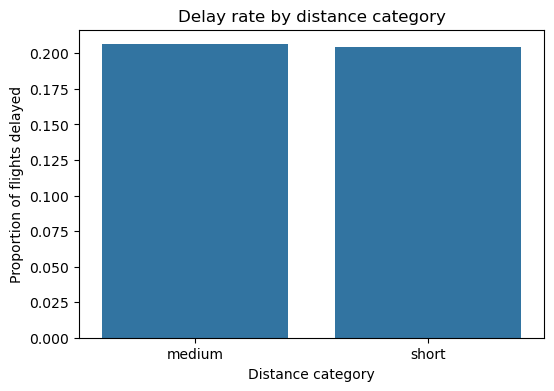

In [23]:
# Delay rate by distance category
delay_by_dist = combined.groupby('distance_cat')['delayed'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='distance_cat', y='delayed', data=delay_by_dist)
plt.xlabel('Distance category')
plt.ylabel('Proportion of flights delayed')
plt.title('Delay rate by distance category')
plt.show()


## 4. Conclusion

In this section of the notebook (to be written up in markdown), you should summarise:

- Key characteristics of the data (e.g. overall delay rate, effect of weather and distance).
- Which classifier performed best and why (based on the accuracy and classification report).
- Which features appear to be most predictive of delay, using the feature importance analysis and exploratory plots as evidence.